In [2]:
%%capture
import laspy
import numpy as np
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
from numba import jit

%run Canopy_Height_Model.ipynb

las = laspy.file.File("data/sample.las")

Determine the minimum and maximum x and y values.

In [4]:
min_x, max_x = las.header.min[0], las.header.max[0]
min_y, max_y = las.header.min[1], las.header.max[1]

Determine the numbers of rows $m$ and columns $n$ for some arbitrary cell size (in this case I will use $c = 1$).

In [3]:
# First we need to modify our grid function slightly

def grid(las, c):
    # Determine the number of rows (m) and columns (n)
    # Some python interpreters complain about the np float datatype
    # So we will convert to integers just in case
    m = int(np.floor((max(las.y) - min(las.y)) / c) + 1)
    n = int(np.floor((max(las.x) - min(las.x)) / c) + 1)
    
    # Create bins
    bins_x = np.digitize(las.x, np.linspace(min(las.x), max(las.x), n))
    bins_y = np.digitize(las.y, np.linspace(min(las.y), max(las.y), m))

    # Add bins and las data to a new dataframe
    df = pd.DataFrame({'x': las.x, 'y': las.y, 'z': las.z, 'bins_x': bins_x, 'bins_y': bins_y})
    return(df)

In [307]:
c = 1
m = np.floor((max_y - min_y) / c) + 1
n = np.floor((max_x - min_x) / c) + 1

Sort the points into grid cells, find the minimum z value in each grid cell.

In [308]:
# Flag the points that are the minimum z value for their cell
df = grid(las, c)
idx = df.groupby(['bins_x', 'bins_y'])['z'].transform(min) == df['z']
df['min_z'] = idx
df.head()

,bins_x,bins_y,x,y,z,min_z
0,1,2,470094.87,5016466.27,521.20,False
1,1,1,470094.93,5016465.58,521.78,False
2,1,1,470095.31,5016465.31,521.83,False
3,1,2,470095.27,5016465.97,521.83,False
4,1,2,470095.12,5016466.78,518.73,False


Next we need to find the empty cells. This is a bit tricky. My approach was to sort the dataframe from the previous step by `bins_x` and then `bins_y` (this makes detection of missing values easier later on). For each value of `bins_x` we find the missing values in the sequence of 1 to `m`. We then generate a numpy array for later use.

In [309]:
# First, selecting only the minimum coordinate values.
min_df = df[df['min_z']]

# Then sort and convert to array
min_df_sorted = min_df.sort_values(['bins_x', 'bins_y'])
my_pairs = np.array(min_df[['bins_x', 'bins_y']])

Now we need some helper functions. The first, `missing_elements` detects missing numbers in a given sequence, this will, for each value of `x_bin`, find the missing `y_bins`. The `find_missing_cells` function wraps everything we need together.

TODO: Not very straightfoward, may be best to do some sort of permutation approach, or there may be a direct pandas solution. This also assumes that all bins are filled in the x dimension.

In [310]:
def missing_elements(L, max_val):
    start, end = L[0], max_val
    return(sorted(set(range(start, end + 1)).difference(L)))

def find_missing_cells(x_bins):
    arr = np.empty((0, 2))
    for x_bin in x_bins:    
        b = min_df_sorted.loc[min_df_sorted['bins_x'] == x_bin]
        L = list(b['bins_y'])
        missing = missing_elements(L, int(m))
        # Create numpy array
        ones = np.full(len(missing), x_bin)
        vals = np.array(missing)
        stacked = np.stack((ones, vals), axis = 1)
        arr = np.append(arr, stacked, axis = 0)
    return(arr)

x_bins = min_df_sorted['bins_x'].unique()
missing = find_missing_cells(x_bins)
missing

array([[   1.,  100.],
       [   3.,  100.],
       [   7.,  100.],
       [   9.,  100.],
       [  10.,  100.],
       [  12.,  100.],
       [  13.,  100.],
       [  14.,  100.],
       [  15.,  100.],
       [  16.,  100.],
       [  19.,  100.],
       [  23.,  100.],
       [  27.,  100.],
       [  28.,  100.],
       [  35.,  100.],
       [  38.,  100.],
       [  39.,  100.],
       [  40.,  100.],
       [  42.,  100.],
       [  46.,  100.],
       [  47.,  100.],
       [  48.,  100.],
       [  49.,  100.],
       [  50.,  100.],
       [  56.,  100.],
       [  57.,  100.],
       [  58.,  100.],
       [  59.,  100.],
       [  60.,  100.],
       [  61.,  100.],
       [  62.,  100.],
       [  63.,  100.],
       [  64.,  100.],
       [  66.,  100.],
       [  67.,  100.],
       [  68.,  100.],
       [  69.,  100.],
       [  72.,  100.],
       [  75.,  100.],
       [  77.,  100.],
       [  79.,  100.],
       [  83.,  100.],
       [  84.,  100.],
       [  8

We are now ready for Zhang's next step:

Interpolate elevation of cells in $A$ which do
not contain any points using the nearest neighbor
method. Set the x and y coordinates of those interpolated
cells as zero to distinguish them from
those cells that contain LIDAR points. Copy A to
B. Initialize elements of a 2-D integer array
$flag[m; n]$ with 0.

First we need to translate the bin cell indices to our point cloud space (in this case UTM 10). This can be done with a simple linear transformation, `translate_bin`.

In [311]:
def translate_bin(x_bin, y_bin, las):
    new_x = ( (x_bin - 1) / (n - 1) ) * (las.header.max[0] - las.header.min[0]) + las.header.min[0]
    new_y = ( (y_bin -1) / (m -1) ) * (las.header.max[1] - las.header.min[1]) + las.header.min[1]
    return(np.stack((new_x, new_y), axis = 1))

# Translate the missing bins into UTM 10 N space.
missing_centers = translate_bin(missing[:,0], missing[:,1], las)
missing_centers

array([[  470094.85,  5016564.81],
       [  470096.87,  5016564.81],
       [  470100.91,  5016564.81],
       [  470102.93,  5016564.81],
       [  470103.94,  5016564.81],
       [  470105.96,  5016564.81],
       [  470106.97,  5016564.81],
       [  470107.98,  5016564.81],
       [  470108.99,  5016564.81],
       [  470110.  ,  5016564.81],
       [  470113.03,  5016564.81],
       [  470117.07,  5016564.81],
       [  470121.11,  5016564.81],
       [  470122.12,  5016564.81],
       [  470129.19,  5016564.81],
       [  470132.22,  5016564.81],
       [  470133.23,  5016564.81],
       [  470134.24,  5016564.81],
       [  470136.26,  5016564.81],
       [  470140.3 ,  5016564.81],
       [  470141.31,  5016564.81],
       [  470142.32,  5016564.81],
       [  470143.33,  5016564.81],
       [  470144.34,  5016564.81],
       [  470150.4 ,  5016564.81],
       [  470151.41,  5016564.81],
       [  470152.42,  5016564.81],
       [  470153.43,  5016564.81],
       [  470154.44,

In [312]:
# Construct the interpolator
coords = np.array(min_df_sorted[['x', 'y']])
z = np.array(min_df_sorted['z'])
interp2 = NearestNDInterpolator(coords, z)

interp_elevs = interp2(missing_centers)
interp_elevs

array([ 495.81,  521.07,  497.08,  509.63,  497.1 ,  505.42,  497.62,
        504.92,  507.52,  508.28,  518.  ,  512.67,  522.17,  496.45,
        496.46,  496.66,  496.89,  496.99,  497.18,  497.44,  497.52,
        505.02,  509.95,  512.29,  508.47,  497.52,  497.59,  497.56,
        516.6 ,  516.6 ,  497.71,  497.71,  500.83,  519.78,  497.16,
        497.16,  497.11,  519.89,  521.4 ,  496.82,  528.78,  498.23,
        516.24,  516.24,  527.64,  530.3 ,  530.95,  490.47,  465.1 ,
        465.1 ,  501.82,  465.98,  466.47,  466.76,  466.85,  466.85,
        492.21,  514.68,  468.19,  479.01,  506.95,  505.88,  508.64,
        513.93,  474.91,  507.79,  477.65,  480.31,  480.31,  477.77,
        481.53,  481.44,  480.99,  480.99,  519.25,  481.86,  481.67,
        482.27,  482.44,  484.7 ,  485.5 ,  481.46,  500.42,  499.88,
        498.85,  483.38,  517.47,  483.84,  520.29,  485.75,  485.63,
        485.68,  531.9 ,  486.69,  487.33,  491.87,  488.37,  530.72,
        490.42,  490

Almost there. Now we just need to append these missing cells and their interpolated values back to our original dataframe `df`.

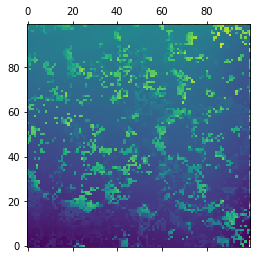

In [313]:
missing = missing.astype(int)
interp_elevs.shape

interp_add = pd.DataFrame({'bins_x': missing[:,0], 'bins_y': missing[:,1], 'z': interp_elevs})
df_synthetic = min_df.append(interp_add)

df_synthetic

def matrix_plot(gridded_df):
    # Group by the x and y grid cells
    group_df = gridded_df[['bins_x', 'bins_y', 'z']].groupby(['bins_x', 'bins_y'])
    
    # Summarize (i.e. aggregate) on the max z value and reshape the dataframe into a 2d matrix
    plot_mat = group_df.agg({'z': 'min'}).reset_index().pivot('bins_y', 'bins_x', 'z')
    
    # Plot the matrix, and invert the y axis to orient the 'image' appropriately
    plt.matshow(plot_mat)
    plt.gca().invert_yaxis()
    
    # Show the matrix image
    plt.show()

matrix_plot(df_synthetic)

5. Determine series of w using (4) or (5), where
w  maximum window size.
6. dh = dh
7. for each window size w
8. for i = 1 to m
9. P = A[i; ] (A[i; ] represents a row of points at
row i in A and P is a 1-D array)
10. Z P i (Assign elevation values from P to a
1-D elevation array Z)
11. Z = erosion(Z;w )
12. Z = dilation(Z ; w )
13. P Z (Replace z values of P with the values
from Z )
14. A[i;] = P (Put the filtered row of points P
back to row i of array A)
15. for j = 1 to n
16. if Z[j]
Z [j] > dh then ag[i; j] = w
17. end for j loop
18. end for i loop
19. if (dh > dh )
20. dh = dh
21. else
22. dh = s(w
w )c + dh
23. end for window size loop
24. for i = 1 to m
25. for j = 1 to n
26. if (B[i; j](x) > 0 and B[i; j](y) > 0)
27. if (ag[i; j]=0)
28. B[i; j] is a ground point
29. else
30. B[i; j] is a nonground point
31. end for j loop
32. end for i 
op
Erosion(Z; w ):
1. for j = 1 to n
2. Z [j] = min (Z[l])
3. return Z
Dilation(Z; w ):
1. for j = 1 to n
2. Z [j] = max (Z[l])
3. retu